In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
plt.style.use('seaborn-white')

In [2]:
log_directory = '../../../data/raw/logs/'

In [4]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [5]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, dir_path + "/" + filename))
    return result

In [6]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [7]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [8]:
def producer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt/10"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["event"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
        variant_dfs["processing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    return result

In [9]:
def consumer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["e2e"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_(\d+)_e2e_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    return result

In [10]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

# Identify sustainable throughput

In [37]:
dataframes = consumer_dfs(log_directory + "20200727/e2e/")

In [35]:
dataframes["exclusive"]["e2e"].head()

,index,Latency in us,Message Size in Bytes,Rate Limit in MB/s
0,0,104,131072,3600
1,1,69,131072,3600
2,2,95,131072,3600
3,3,137,131072,3600
4,4,123,131072,3600


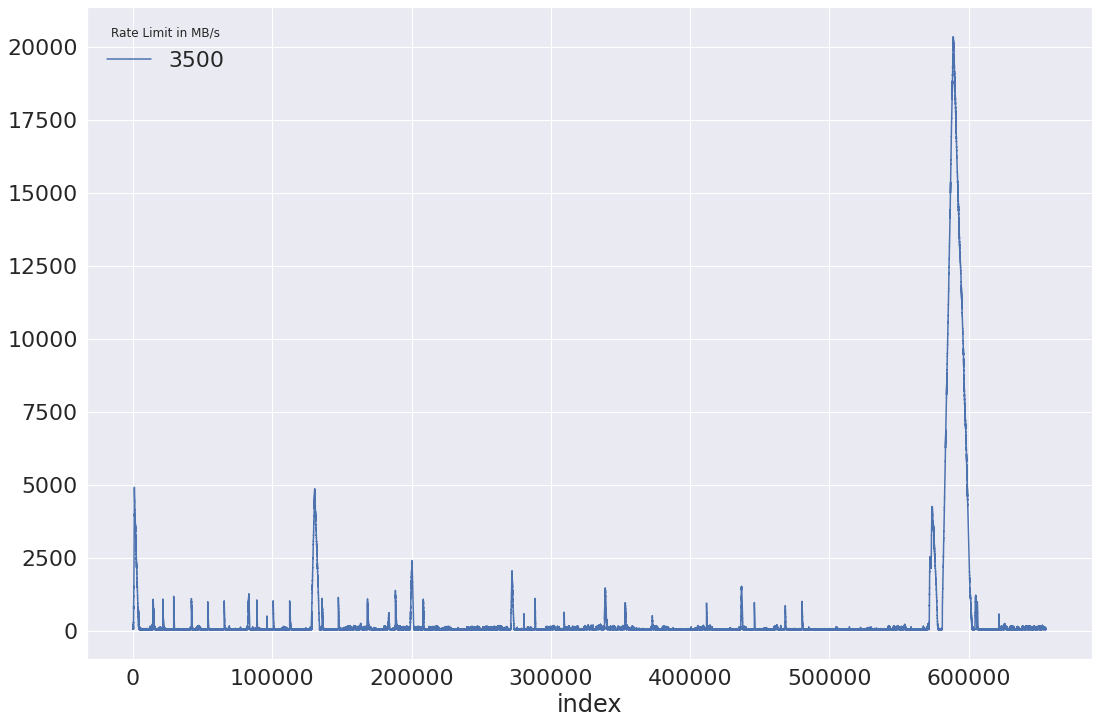

In [25]:
plot_timeseries(dataframes["exclusive"]["e2e"][dataframes["exclusive"]["e2e"]["Rate Limit in MB/s"] <= 3500], "Latency in us")

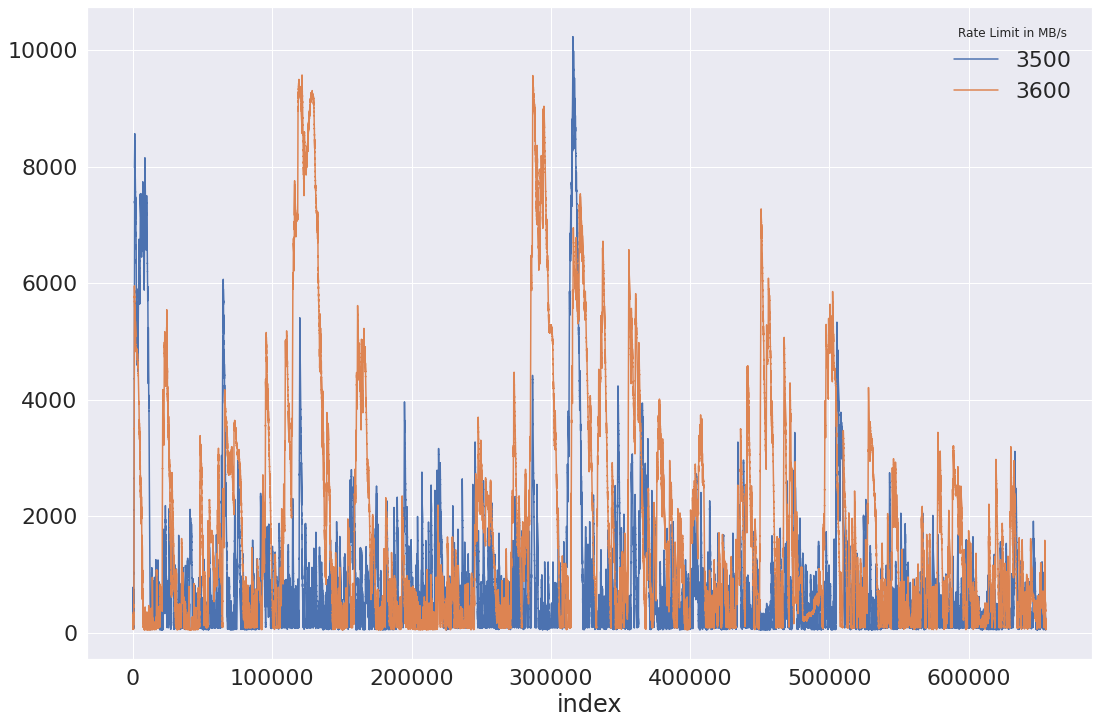

In [38]:
plot_timeseries(dataframes["exclusive_opt"]["e2e"][dataframes["exclusive_opt"]["e2e"]["Rate Limit in MB/s"] <= 3600], "Latency in us")

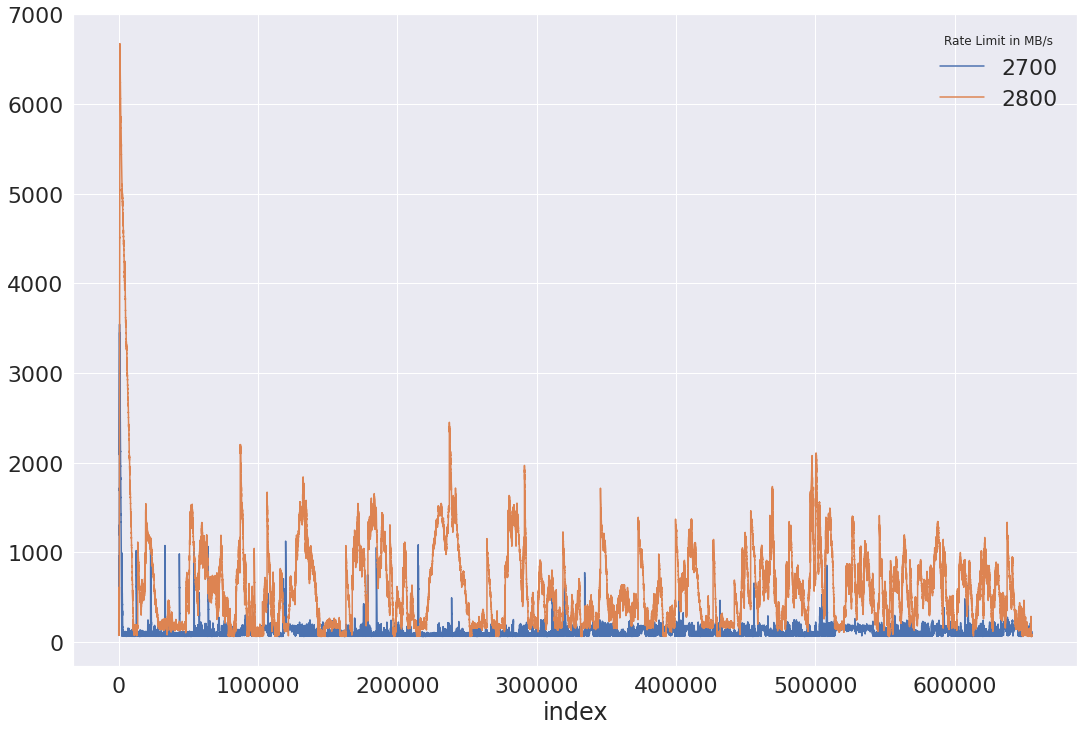

In [39]:
plot_timeseries(dataframes["concurrent"]["e2e"][dataframes["concurrent"]["e2e"]["Rate Limit in MB/s"] <= 2800], "Latency in us")

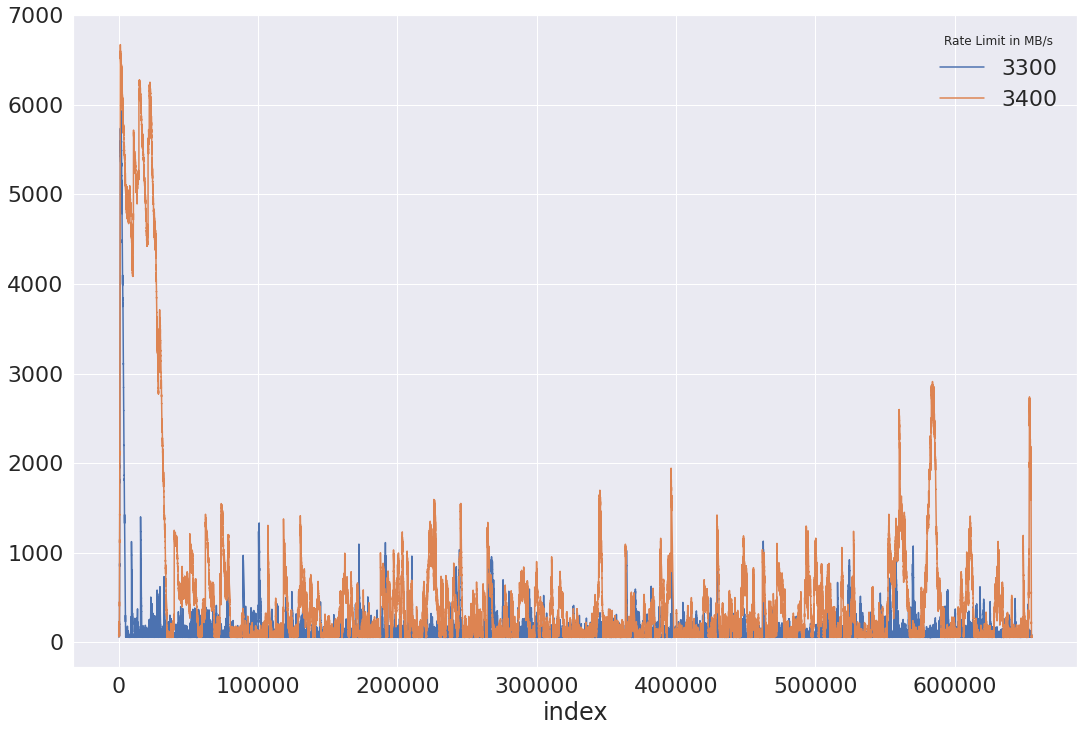

In [41]:
plot_timeseries(dataframes["concurrent_opt"]["e2e"][dataframes["concurrent_opt"]["e2e"]["Rate Limit in MB/s"] <= 3400], "Latency in us")

In [80]:
max_sust_tps[3].head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol
0,0,26892,3524.788,131072,90,3500,Concurrent Opt. (10)
1,1,27126,3555.459,131072,90,3500,Concurrent Opt. (10)
2,2,27022,3541.828,131072,90,3500,Concurrent Opt. (10)
3,3,27074,3548.643,131072,90,3500,Concurrent Opt. (10)
4,4,27043,3544.580,131072,90,3500,Concurrent Opt. (10)


In [86]:
max_sust_tps = [dataframes["exclusive"]["tp"][dataframes["exclusive"]["tp"]["Rate Limit in MB/s"] == 3500],
                dataframes["exclusive_opt"]["tp"][dataframes["exclusive_opt"]["tp"]["Rate Limit in MB/s"] == 3600],
                dataframes["concurrent"]["tp"][dataframes["concurrent"]["tp"]["Rate Limit in MB/s"] == 2800],
                dataframes["concurrent_opt/10"]["tp"][dataframes["concurrent_opt/10"]["tp"]["Rate Limit in MB/s"] == 3400]]
max_sust_tps[0]["Protocol"] = "Exclusive"
max_sust_tps[1]["Protocol"] = "Exclusive Opt."
max_sust_tps[2]["Protocol"] = "Concurrent"
max_sust_tps[3]["Protocol"] = "Concurrent Opt. (10)"
max_sust_tps_df = pd.concat(max_sust_tps)

<ipython-input-86-a5e4f9a29f21>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_sust_tps[0]["Protocol"] = "Exclusive"
<ipython-input-86-a5e4f9a29f21>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_sust_tps[1]["Protocol"] = "Exclusive Opt."
<ipython-input-86-a5e4f9a29f21>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

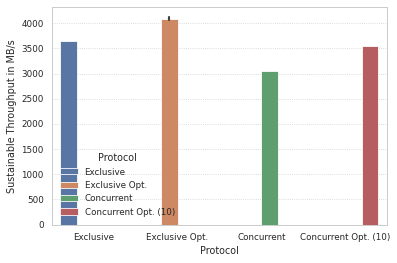

In [88]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Throughput in MB/s", hue="Protocol", data=max_sust_tps_df, ci="sd")
g.set_ylabel("Sustainable Throughput in MB/s")
g.get_figure().savefig("ghostwriter_sustainable_throughput", bbox_inches="tight", dpi=600)

In [112]:
max_event_lat = [dataframes["exclusive"]["event"][dataframes["exclusive"]["event"]["Rate Limit in MB/s"] == 3600],
                dataframes["exclusive_opt"]["event"][dataframes["exclusive_opt"]["event"]["Rate Limit in MB/s"] == 3900],
                dataframes["concurrent"]["event"][dataframes["concurrent"]["event"]["Rate Limit in MB/s"] == 3000],
                dataframes["concurrent_opt/10"]["event"][dataframes["concurrent_opt/10"]["event"]["Rate Limit in MB/s"] == 3500]]
max_event_lat[0]["Protocol"] = "Exclusive"
max_event_lat[1]["Protocol"] = "Exclusive Opt."
max_event_lat[2]["Protocol"] = "Concurrent"
max_event_lat[3]["Protocol"] = "Concurrent Opt. (10)"
max_event_lat_df = pd.concat(max_event_lat)

<ipython-input-112-30eb0d4a73b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_event_lat[0]["Protocol"] = "Exclusive"
<ipython-input-112-30eb0d4a73b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_event_lat[1]["Protocol"] = "Exclusive Opt."
<ipython-input-112-30eb0d4a73b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [102]:
max_event_lat_df.head()

,index,Avg. Latency in us,Min. Latency in us,Max. Latency in us,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol
0,0,76.0,76,76,131072,90,3600,Exclusive
1,1,75.0,75,75,131072,90,3600,Exclusive
2,2,96.0,96,96,131072,90,3600,Exclusive
3,3,142.0,142,142,131072,90,3600,Exclusive
4,4,161.0,161,161,131072,90,3600,Exclusive


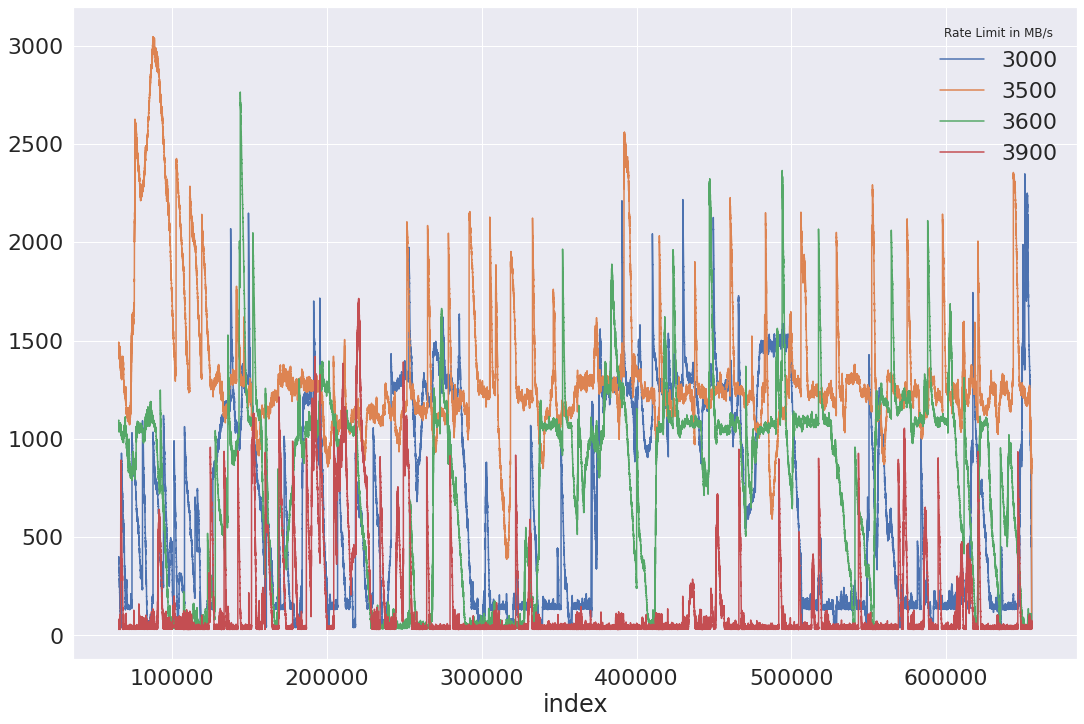

In [124]:
plot_timeseries(max_event_lat_df[max_event_lat_df["index"]>= 65536], "Avg. Latency in us")

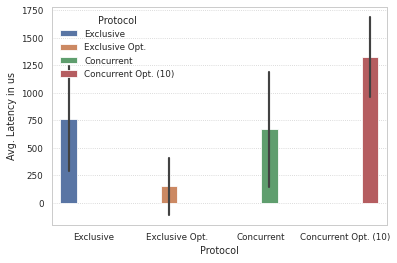

In [128]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Avg. Latency in us", hue="Protocol", data=max_event_lat_df[max_event_lat_df["index"]>= 65536], ci="sd")
g.get_figure().savefig("ghostwriter_event_latency_100", bbox_inches="tight", dpi=600)

In [152]:
event_lat_90 = [dataframes["exclusive"]["event"][dataframes["exclusive"]["event"]["Rate Limit in MB/s"] == 3300],
                dataframes["exclusive_opt"]["event"][dataframes["exclusive_opt"]["event"]["Rate Limit in MB/s"] == 3600],
                dataframes["concurrent"]["event"][dataframes["concurrent"]["event"]["Rate Limit in MB/s"] == 2700],
                dataframes["concurrent_opt/10"]["event"][dataframes["concurrent_opt/10"]["event"]["Rate Limit in MB/s"] == 3200]]
event_lat_90[0]["Protocol"] = "Exclusive"
event_lat_90[1]["Protocol"] = "Exclusive Opt."
event_lat_90[2]["Protocol"] = "Concurrent"
event_lat_90[3]["Protocol"] = "Concurrent Opt. (10)"
event_lat_90_df = pd.concat(event_lat_90)

<ipython-input-152-78f31dacb843>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_lat_90[0]["Protocol"] = "Exclusive"
<ipython-input-152-78f31dacb843>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_lat_90[1]["Protocol"] = "Exclusive Opt."
<ipython-input-152-78f31dacb843>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

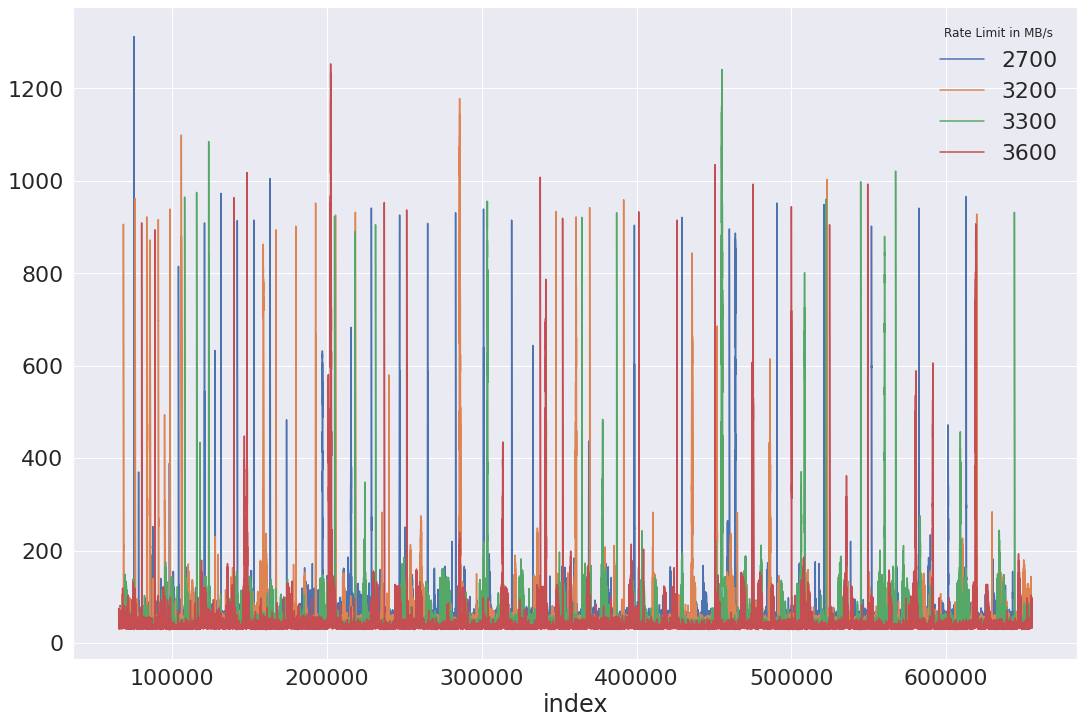

In [156]:
plot_timeseries(event_lat_90_df[event_lat_90_df["index"]>= 65536], "Avg. Latency in us")

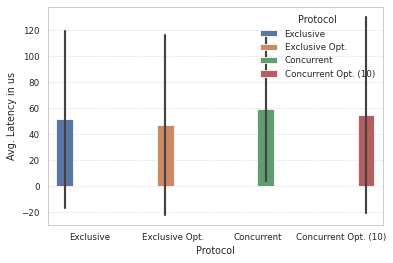

In [157]:
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Avg. Latency in us", hue="Protocol", data=event_lat_90_df[event_lat_90_df["index"]>= 65536], ci="sd")
# g.get_figure().savefig("ghostwriter_event_latency_100", bbox_inches="tight", dpi=600)

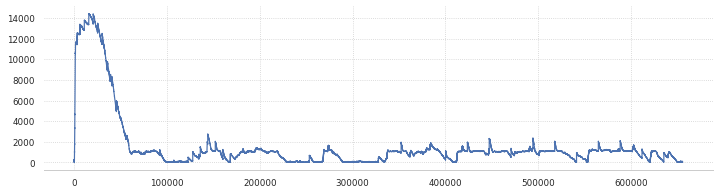

In [151]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = dataframes["exclusive"]["event"][dataframes["exclusive"]["event"]["Rate Limit in MB/s"] == 3600]
ax.plot(df["index"], df["Avg. Latency in us"])
# plt.yscale("log")
plt.savefig("exclusive_100_event_timeline")

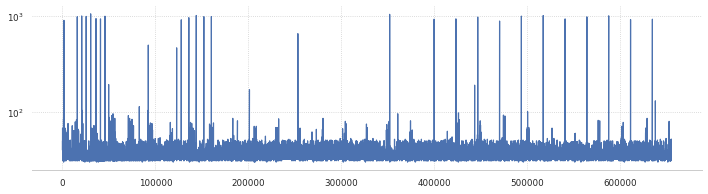

In [150]:
fig_dims = (12, 3)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600]
ax.plot(df["index"], df["Avg. Latency in us"])
plt.yscale("log")
plt.savefig("exclusive_100_processing_timeline")

In [40]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
#     sns.set(font_scale=2)
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [63]:
def plot_comp_histogram(exclusive_df, exclusive_opt_df, measure, filename):
    exclusive_df["Broker"] = "Naive"
    exclusive_opt_df["Broker"] = "Optimized"
    df = pd.concat([exclusive_df, exclusive_opt_df])
    fig, ax = plt.subplots()
    sns.set_context('paper')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y=measure, hue="Broker", data=df, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    g.set_ylabel("Avg. " + measure)
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
    fig.savefig(filename, bbox_inches="tight", dpi=600)

# Consumer Latency

In [32]:
cons_dfs = consumer_dfs(log_directory + "20200727/processing_latency/")

In [41]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt"][measure]]
    df_list[0]["Protocol"] = "Exclusive"
    df_list[1]["Protocol"] = "Exclusive Opt."
    df_list[2]["Protocol"] = "Concurrent"
    df_list[3]["Protocol"] = "Concurrent Opt."
    return pd.concat(df_list)

In [42]:
cons_df = prepare_dfs(cons_dfs, "latency")

In [57]:
cons_df.head()

,index,Latency in us,Message Size in Bytes,Protocol
0,0,26,131072,Exclusive
1,1,25,131072,Exclusive
2,2,25,131072,Exclusive
3,3,24,131072,Exclusive
4,4,24,131072,Exclusive


<Figure size 432x288 with 0 Axes>

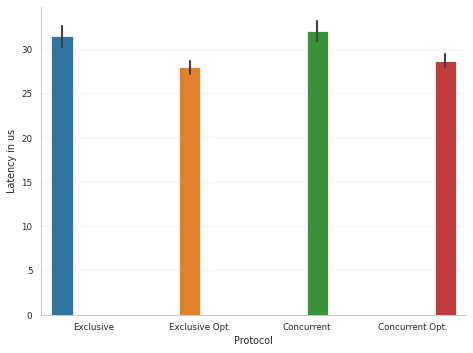

In [58]:
# fig_dims = (16, 3)
# fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
# g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=cons_df, ci="sd")
g = sns.catplot(x="Protocol", y="Latency in us", hue="Protocol", data=cons_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
# ax.plot(cons_df["index"], cons_df["Latency in us"])
# plt.yscale("log")
g.savefig("consumer_latency.png")